# BTCUSD Data

In [1]:
import pandas as pd

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover

C:\Users\antho\Anaconda3\lib\site-packages\backtesting\_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from backtesting import Backtest

In [4]:
%matplotlib inline
import seaborn as sns
from Price_Data import hist_data

In [5]:
import matplotlib.pyplot as plt

In [6]:
btcusd = hist_data('Bitstamp')

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
btcusd.columns = ['Open']

In [8]:
ss = btcusd.resample('H')

In [9]:
op = ss.first().ffill()
hi = ss.max().ffill()
lo = ss.min().ffill()
cl = ss.last().ffill()

In [10]:
btcusd

,Open
Date,
2011-09-13 13:53:36,5.80
2011-09-13 13:53:44,5.83
2011-09-13 13:53:49,5.90
2011-09-13 13:53:54,6.00
2011-09-13 14:32:53,5.95
...,...
2019-12-12 23:58:18,7184.44
2019-12-12 23:58:20,7184.44
2019-12-12 23:59:05,7190.53


In [11]:
ohlc = op
ohlc.columns = ['Open']
ohlc['High'] = hi
ohlc['Low'] = lo
ohlc['Close'] = cl
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-13 13:00:00,5.80,6.00,5.80,6.00
2011-09-13 14:00:00,5.95,5.95,5.76,5.76
2011-09-13 15:00:00,5.65,5.65,5.65,5.65
2011-09-13 16:00:00,5.65,5.65,5.65,5.65
2011-09-13 17:00:00,5.65,5.65,5.65,5.65
...,...,...,...,...
2019-12-12 19:00:00,7205.66,7218.00,7186.36,7193.66
2019-12-12 20:00:00,7205.14,7250.23,7195.00,7242.49
2019-12-12 21:00:00,7245.85,7253.68,7180.83,7194.57


In [12]:
import datetime as dt

In [25]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

# Strategies

In [14]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [96]:
class SmaCross(Strategy):
    
    n1 = 201
    n2 = 951
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [16]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [17]:
class EmaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [18]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [19]:
class DemaCross(Strategy):
    
    n1 = 37
    n2 = 46
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

In [20]:
import scipy.interpolate as interp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# S&P 500 Data

In [21]:
import yfinance as yf

In [22]:
sp_df = yf.download('^GSPC', 
                      start='2011-09-13', 
                      end='2019-12-13', 
                      progress=False,interval='1d')
sphlc = sp_df.iloc[:,:4]
sphlc

,Open,High,Low,Close
Date,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010
...,...,...,...,...
2019-12-06,3134.620117,3150.600098,3134.620117,3145.909912
2019-12-09,3141.860107,3148.870117,3135.459961,3135.959961
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020


In [26]:
sp1 = sphlc.loc['2018-12-12':]
sp2 = sphlc.loc['2017-12-12':]
sp4 = sphlc.loc['2015-12-12':]

In [120]:
bt = Backtest(yr1,SmaCross,cash=10000)
btc,hm= bt.optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


In [121]:
st = Backtest(sp1,SmaCross,cash=10000)
data,sm= st.optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2,return_heatmap=True)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


# Correlation Analysis

In [47]:
a = st.run()._trade_data
b = bt.run()._trade_data

In [114]:
b

,Equity,Exit Entry,Exit Position,Entry Price,Exit Price,P/L,Returns,Drawdown,Drawdown Duration
Date,,,,,,,,,
2018-12-12 00:00:00,10000.000000,NaN,NaN,NaN,NaN,0.0,NaN,0.000000,NaT
2018-12-12 01:00:00,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaT
2018-12-12 02:00:00,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaT
2018-12-12 03:00:00,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaT
2018-12-12 04:00:00,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaT
...,...,...,...,...,...,...,...,...,...
2019-12-12 19:00:00,33131.073579,NaN,NaN,NaN,NaN,NaN,NaN,0.052752,NaT
2019-12-12 20:00:00,32912.417217,NaN,NaN,NaN,NaN,NaN,NaN,0.059003,NaT
2019-12-12 21:00:00,33126.998681,NaN,NaN,NaN,NaN,NaN,NaN,0.052868,NaT


In [50]:
ap = a['P/L']
bp = b['P/L']

In [55]:
ap = ap.interpolate(method='time')

In [61]:
ap[0] = 0

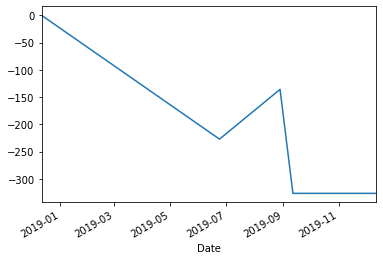

In [63]:
ap = ap.interpolate(method='time')
ap.plot()

In [65]:
bp[0] = 0
bp = bp.interpolate(method='time')

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


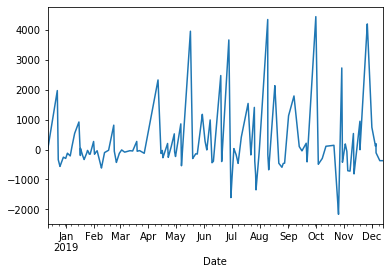

In [67]:
bp.plot()

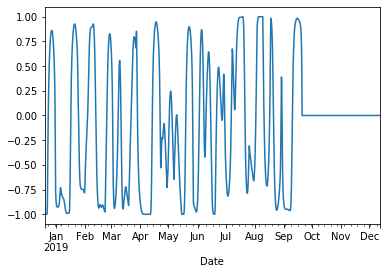

In [94]:
ap = ap.asfreq('H')
ap = ap.interpolate('time')
ap.rolling(200).corr(bp).dropna().plot()

In [97]:
bt = Backtest(yr1,SmaCross,cash=10000)

In [99]:
bp = bt.run()._trade_data['P/L']

In [102]:
bp[0] = 0

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
bp = bp.interpolate(method='time')

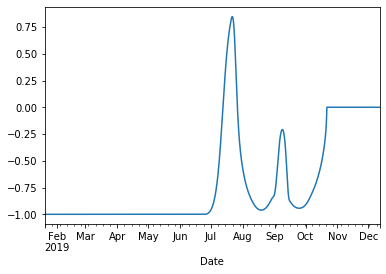

In [113]:
ap.rolling(951).corr(bp).dropna().plot()

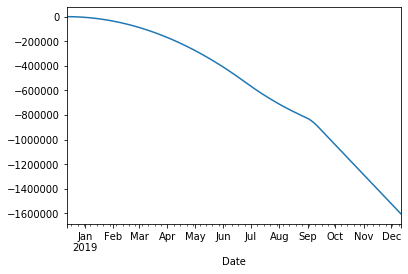

In [118]:
ap.cumsum().plot()

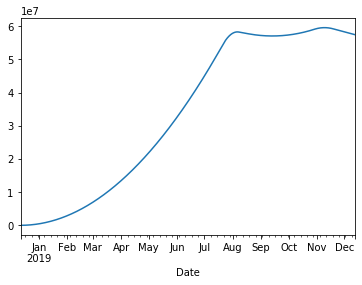

In [119]:
bp.cumsum().plot()

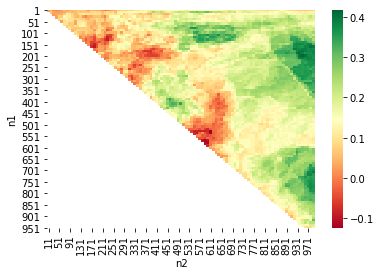

In [129]:
hm.sort_values()
hmap = hm.groupby(['n1','n2']).mean().unstack()
sns.heatmap(hmap,cmap='RdYlGn')